In [ ]:
%load_ext autoreload
%autoreload 2

import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, os.path.join(parent_dir)) 

from coord2vec.models.losses import ScaledLoss
import argparse as argparse
import numpy as np
import random
import torch
from torch.backends import cudnn

from coord2vec.common.expr_util import save_all_py_files
from coord2vec.models.data_loading.tile_features_loader import TileFeaturesDataset
from coord2vec.config import VAL_CACHE_DIR, TRAIN_CACHE_DIR, get_builder, EXPR_NAME
from coord2vec.models.baselines import Coord2Vec
import matplotlib.pyplot as plt
from coord2vec.experiments.train import main
print("loaded")

In [ ]:
TRAIN_CACHE_DIR

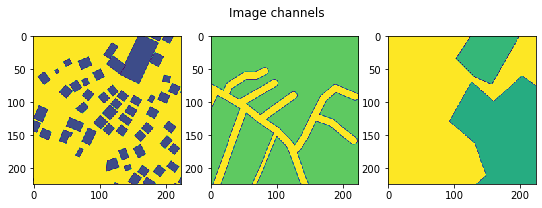

[(['nearest_neighbour_building_50m'], tensor(0.)), (['area_of_building_50m'], tensor(227.2977)), (['number_of_building_50m'], tensor(17.)), (['nearest_neighbour_park_50m'], tensor(50.)), (['area_of_park_50m'], tensor(0.)), (['number_of_park_50m'], tensor(0.)), (['nearest_neighbour_road_50m'], tensor(10.9862)), (['length_of_road_50m'], tensor(226.2148)), (['number_of_road_50m'], tensor(6.))]


In [8]:
builder = get_builder()

train_dataset = TileFeaturesDataset(TRAIN_CACHE_DIR, builder)
val_dataset = TileFeaturesDataset(VAL_CACHE_DIR, builder)


sample_ind = 3

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
axs[0].imshow(train_dataset[sample_ind][0][0])
axs[1].imshow(train_dataset[sample_ind][0][1])
axs[2].imshow(train_dataset[sample_ind][0][2])
fig.suptitle('Image channels')
plt.show()

features = [feature.feature_names for feature in builder.features]
print(list(zip(features, train_dataset[sample_ind][1])))

In [10]:
parser = argparse.ArgumentParser()
parser.add_argument('-f')
parser.add_argument('--batch_size', type=int, default=64, help='input batch size')
parser.add_argument('--embedding_size', type=int, default=512)
parser.add_argument('--n_feats', type=int, default=9)
parser.add_argument('--start_lr', type=float, default=1e-4)
parser.add_argument('--lr_steps', nargs='+', default=[20_000, 40_000, 60_000], help='List of steps in which we apply an LR step')
parser.add_argument('--lr_gamma', type=float, default=0.1, help='gamma to multiply each lr step')

# parser.add_argument('--hidden_size', type=int, default=32)
# parser.add_argument('--exp_dir', type=str, default='experiments/2019_11_30_hidden_32')
parser.add_argument('--nepoch', type=int, default=200)
parser.add_argument('--manualSeed', type=int, default=42)
parser.add_argument('--save_interval', type=int, default=1000)
parser.add_argument('--val_interval', type=int, default=500)
opt = parser.parse_args()
print(opt)
print(TRAIN_CACHE_DIR, VAL_CACHE_DIR)

random.seed(opt.manualSeed)
np.random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)

cudnn.benchmark = True


save_all_py_files()

coord2vec = Coord2Vec(get_builder(), n_channels=3, embedding_dim=opt.embedding_size, lr=opt.start_lr,
                      lr_steps=opt.lr_steps, lr_gamma=opt.lr_gamma)
coord2vec.fit(train_dataset, val_dataset, epochs=opt.nepoch, batch_size=opt.batch_size,
              evaluate_every=opt.val_interval, save_every=opt.save_interval)


Namespace(batch_size=64, embedding_size=512, f='/run/user/1002/jupyter/kernel-c8e49e08-8701-4a6e-95ea-4048482d5681.json', lr_gamma=0.1, lr_steps=[20000, 40000, 60000], manualSeed=42, n_feats=9, nepoch=200, save_interval=1000, start_lr=0.0001, val_interval=500)
/media/yonatanz/yz/cache_data/build_road_park_multi_with_norm/train /media/yonatanz/yz/cache_data/build_road_park_multi_with_norm/validation
writing logs to /media/yonatanz/yz/tensorboard_runs/normed_build_park_road_multi_50_000/2019-12-11 08:03:57.875911


ERROR:ignite.engine.engine.Engine:Current run is terminating due to exception: .
ERROR:ignite.engine.engine.Engine:Engine run is terminating due to exception: .


KeyboardInterrupt: 

In [4]:
path = r'../coord2vec/models/saved_models/zarecki_model.pt'
coord2vec.save_trained_model(path)

### Try to fit the network for each feature individualy

In [3]:
from coord2vec.models.data_loading.create_dataset_script import sample_and_save_dataset
from coord2vec.feature_extraction.features_builders import house_price_builder, FeaturesBuilder
from coord2vec.models.data_loading.tile_features_loader import SingleTileFeaturesDataset

n_features = len(house_price_builder.features)

for i in range(n_features):
    print(house_price_builder.features[i].name)
    train_dataset = SingleTileFeaturesDataset(TRAIN_CACHE_DIR, feature_index=i)
    val_dataset = SingleTileFeaturesDataset(VAL_CACHE_DIR, feature_index=i)
    feature_builder = FeaturesBuilder(features=[house_price_builder.features[i]])
    coord2vec = Coord2Vec(feature_builder, n_channels=3 , tb_dir='single_feature')
    coord2vec.fit(train_dataset, val_dataset, epochs=5, batch_size=128)

nearest_building



area_of_building_50m



number_of_building_50m



nearest_park



area_of_park_50m



number_of_park_50m



dist_2_nearest_road



length_of_road_50m



number_of_road_50m


### Try log loss

In [ ]:
log_coord2vec = Coord2Vec(house_price_builder, n_channels=3 ,log_loss=True,  tb_dir='log_loss')
log_coord2vec.fit(dataset, epochs=20, batch_size=64)
pass

### Manual Loss Normalization

In [82]:
features = [feature.name for feature in house_price_builder.features]
max_values = [300, 2500, 6, 900,400 ,0.5, 50,1600,18]
weights = list(map(lambda x: 1/x, max_values))
print(list(zip(features, max_values)))

[('nearest_building', 300), ('area_of_building_50m', 2500), ('number_of_building_50m', 6), ('nearest_park', 900), ('area_of_park_50m', 400), ('number_of_park_50m', 0.5), ('dist_2_nearest_road', 50), ('length_of_road_50m', 1600), ('number_of_road_50m', 18)]


In [17]:
norm_coord2vec = Coord2Vec(house_price_builder, n_channels=3, tb_dir='big_data_model', losses_weights=weights, multi_gpu=True)
norm_coord2vec.fit(dataset, epochs=10, batch_size=128)
pass

In [18]:
path = r'../coord2vec/models/saved_models/big_data_model.pt'
norm_coord2vec.save_trained_model(path)

### Simplest unit test

In [5]:
house_price_builder.features[6].name

'dist_2_nearest_road'

In [2]:
data_path = '/tmp/train_cache/house_price_builder/unit_test'
for feature_index in range(6, len(house_price_builder.features)):
    print(house_price_builder.features[feature_index].name)

    train_dataset = SingleTileFeaturesDataset(data_path, feature_index=feature_index)
    val_dataset = SingleTileFeaturesDataset(data_path, feature_index=feature_index)
    feature_builder = FeaturesBuilder(features=[house_price_builder.features[feature_index]])
    losses = [ScaledLoss()]

    coord2vec = Coord2Vec(feature_builder, n_channels=3 , tb_dir='unit_test_single_feature_lr1e-3', lr=1e-3, losses=losses)
    coord2vec.fit(train_dataset, val_dataset, epochs=250, batch_size=10)
    pass

dist_2_nearest_road



length_of_road_50m



number_of_road_50m


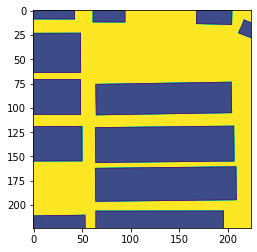

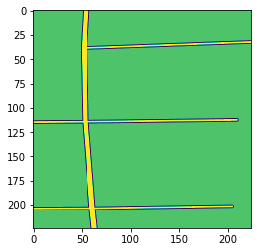

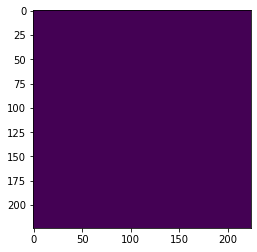

[('nearest_building', tensor(5.1609))]


In [71]:
sample_ind = 2

plt.imshow(train_dataset[sample_ind][0][0])
plt.show()

plt.imshow(train_dataset[sample_ind][0][1])
plt.show()

plt.imshow(train_dataset[sample_ind][0][2])
plt.show()

features = [feature.name for feature in feature_builder.features]
print(list(zip(features, train_dataset[sample_ind][1])))